In [364]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import shapely.wkt
from shapely.geometry import mapping
import ast

In [448]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [449]:
results = pd.read_csv("/content/drive/MyDrive/covid_election_data/nyc_elections.csv")
results.set_index(["Unit Name", "AD", "ED"], inplace=True)

In [450]:
results.head()

,,,Tally
Unit Name,AD,ED,
Public Counter,65,1,393
Manually Counted Emergency,65,1,0
Absentee / Military,65,1,263
Federal,65,1,7
Special Presidential,65,1,0


In [451]:
candidates = [
  'Joseph R. Biden / Kamala D. Harris (Democratic)',
  'Joseph R. Biden / Kamala D. Harris (Working Families)',
  'Donald J. Trump / Michael R. Pence (Republican)',
  'Donald J. Trump / Michael R. Pence (Conservative)',
  'Howie Hawkins / Angela Nicole Walker (Green)',
  'Jo Jorgensen / Jeremy Cohen (Libertarian)',
  'Brock Pierce / Karla Ballard (Independence)',
]

In [452]:
biden_names = [candidates[0], candidates[1]]
trump_names = [candidates[2], candidates[3]]

In [453]:
biden_results = sum(map(lambda name: results.loc[name], biden_names))
trump_results = sum(map(lambda name: results.loc[name], trump_names))
totals = sum(map(lambda name: results.loc[name], candidates)) + results.loc["Scattered"].reindex(trump_results.index).fillna(0)

In [454]:
biden_percentage = (biden_results / totals).fillna(0)
trump_percentage = (trump_results / totals).fillna(0)
biden_margin = biden_percentage - trump_percentage

In [455]:
modzcta = pd.read_csv("/content/drive/MyDrive/covid_election_data/Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv")

In [456]:
modzcta_polygons = {}
for code, shape in zip(modzcta["MODZCTA"], modzcta["the_geom"]):
  modzcta_polygons[code] = shapely.wkt.loads(shape)

In [458]:
nyed = pd.read_csv("/content/drive/MyDrive/covid_election_data/nyed.csv")

In [459]:
nyed_polygons = {}
for code, shape in zip(nyed["ElectDist"], nyed["the_geom"]):
  nyed_polygons[str(code)] = shapely.wkt.loads(shape)

In [460]:
from collections import defaultdict

zipcode_eds = defaultdict(lambda: [])

for (ed, ed_shape) in nyed_polygons.items():
  for (code, zip_shape) in modzcta_polygons.items():
    if zip_shape.contains(ed_shape.centroid):
      zipcode_eds[code].append(ed)

In [461]:
biden_margin_for_zipcode = {}
for (code, edcodes) in zipcode_eds.items():
  tot = 0
  biden_votes = 0
  trump_votes = 0
  for edcode in edcodes:
    ad = int(edcode[:2])
    ed = int(edcode[2:])
    if (ad, ed) in totals.index:
      tot += totals.loc[(ad, ed)]["Tally"]
      biden_votes += biden_results.loc[(ad, ed)]["Tally"]
      trump_votes += trump_results.loc[(ad, ed)]["Tally"]

  biden_p = biden_votes / tot if tot > 0 else 0
  trump_p = trump_votes / tot if tot > 0 else 0
  biden_margin_for_zipcode[code] = biden_p - trump_p

In [462]:
covid_latest = pd.read_csv("/content/drive/MyDrive/covid_election_data/last7days-by-modzcta.csv")

In [463]:
covid_latest.set_index(["modzcta"], inplace=True)

In [464]:
biden_margins = pd.DataFrame.from_dict(biden_margin_for_zipcode, orient="index").sort_index()
biden_margins.columns = ["biden_margin"]

In [465]:
covid_vs_elections = pd.concat([covid_latest, biden_margins, modzcta.set_index(["MODZCTA"])[["pop_est"]]], axis=1).dropna()

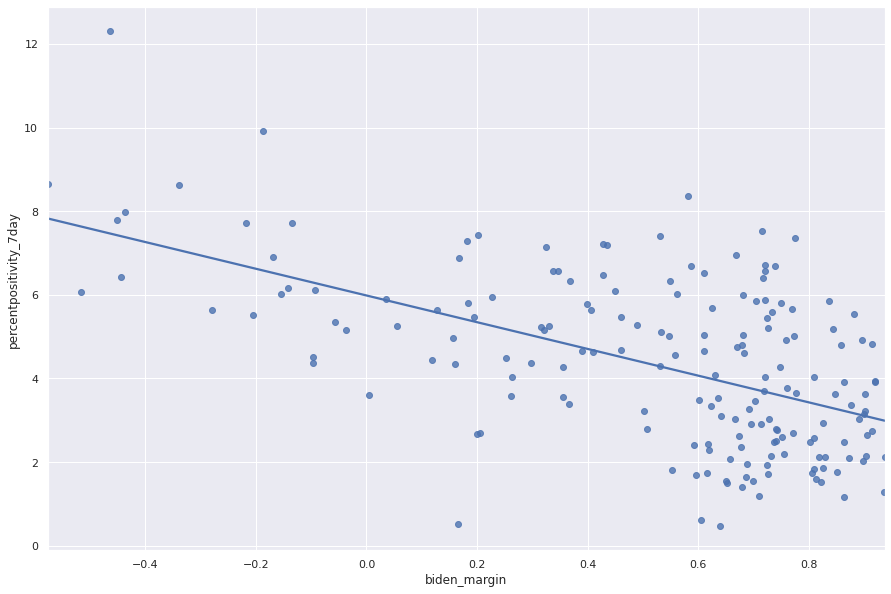

In [466]:
sns.set(rc={'figure.figsize':(15,10)})
sns.regplot(x='biden_margin', y='percentpositivity_7day', data=covid_vs_elections, ci=None, robust=True)

In [469]:
median_income = pd.read_csv("/content/drive/MyDrive/covid_election_data/acs2018_5yr_B19013_86000US10173.csv")
median_income.set_index(["name"], inplace=True)
covid_vs_elections["median_income"] = median_income["B19013001"]

In [470]:
household_info = pd.read_csv("/content/drive/MyDrive/covid_election_data/acs2018_5yr_B11016_86000US10173.csv")
household_info.set_index(["name"], inplace=True)
covid_vs_elections["avg_num_people_per_household"] = covid_vs_elections["pop_est"] / household_info["B11016001"]

In [471]:
# removing Breezy Point outlier with very high case rate and small population
covid_vs_elections.drop(11697, inplace=True)

In [472]:
lm = sm.OLS.from_formula("percentpositivity_7day ~ biden_margin + median_income + avg_num_people_per_household", covid_vs_elections).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     percentpositivity_7day   R-squared:                       0.667
Model:                                OLS   Adj. R-squared:                  0.661
Method:                     Least Squares   F-statistic:                     114.9
Date:                    Sat, 05 Dec 2020   Prob (F-statistic):           7.24e-41
Time:                            22:30:36   Log-Likelihood:                -270.92
No. Observations:                     176   AIC:                             549.8
Df Residuals:                         172   BIC:                             562.5
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        2.5338      0.648      3.910      0.000       1.255       3.813
biden_margin                    -2.5491      0.253    -10.077      0.000      -3.048      -2.050
median_income                -1.626e-05   2.61e-06     -6.216      0.000   -2.14e-05   -1.11e-05
avg_num_people_per_household     1.5964      0.184      8.682      0.000       1.233       1.959
==============================================================================
Omnibus:                        1.984   Durbin-Watson:                   1.602
Prob(Omnibus):                  0.371   Jarque-Bera (JB):                1.705
Skew:                          -0.078   Prob(JB):                        0.426
Kurtosis:                       3.456   Cond. No.                     6.46e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

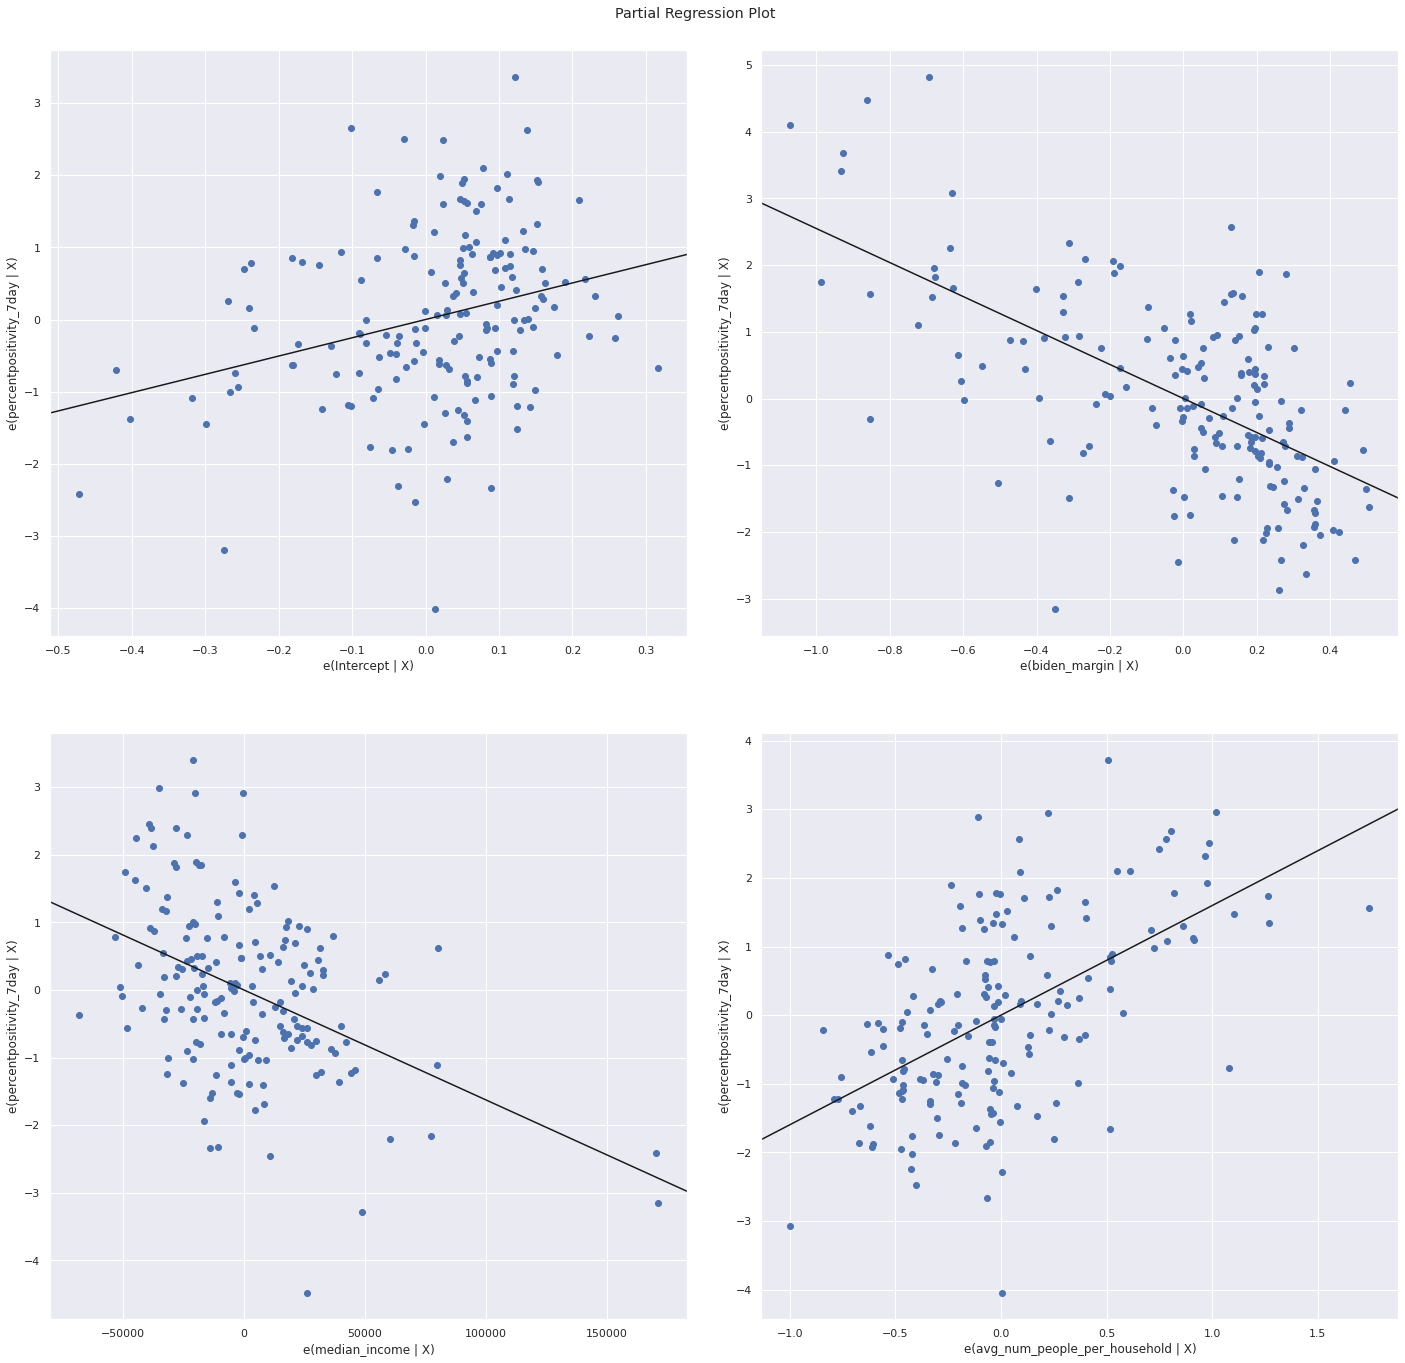

In [473]:
fig = sm.graphics.plot_partregress_grid(lm)
fig.set_size_inches(20, 20)

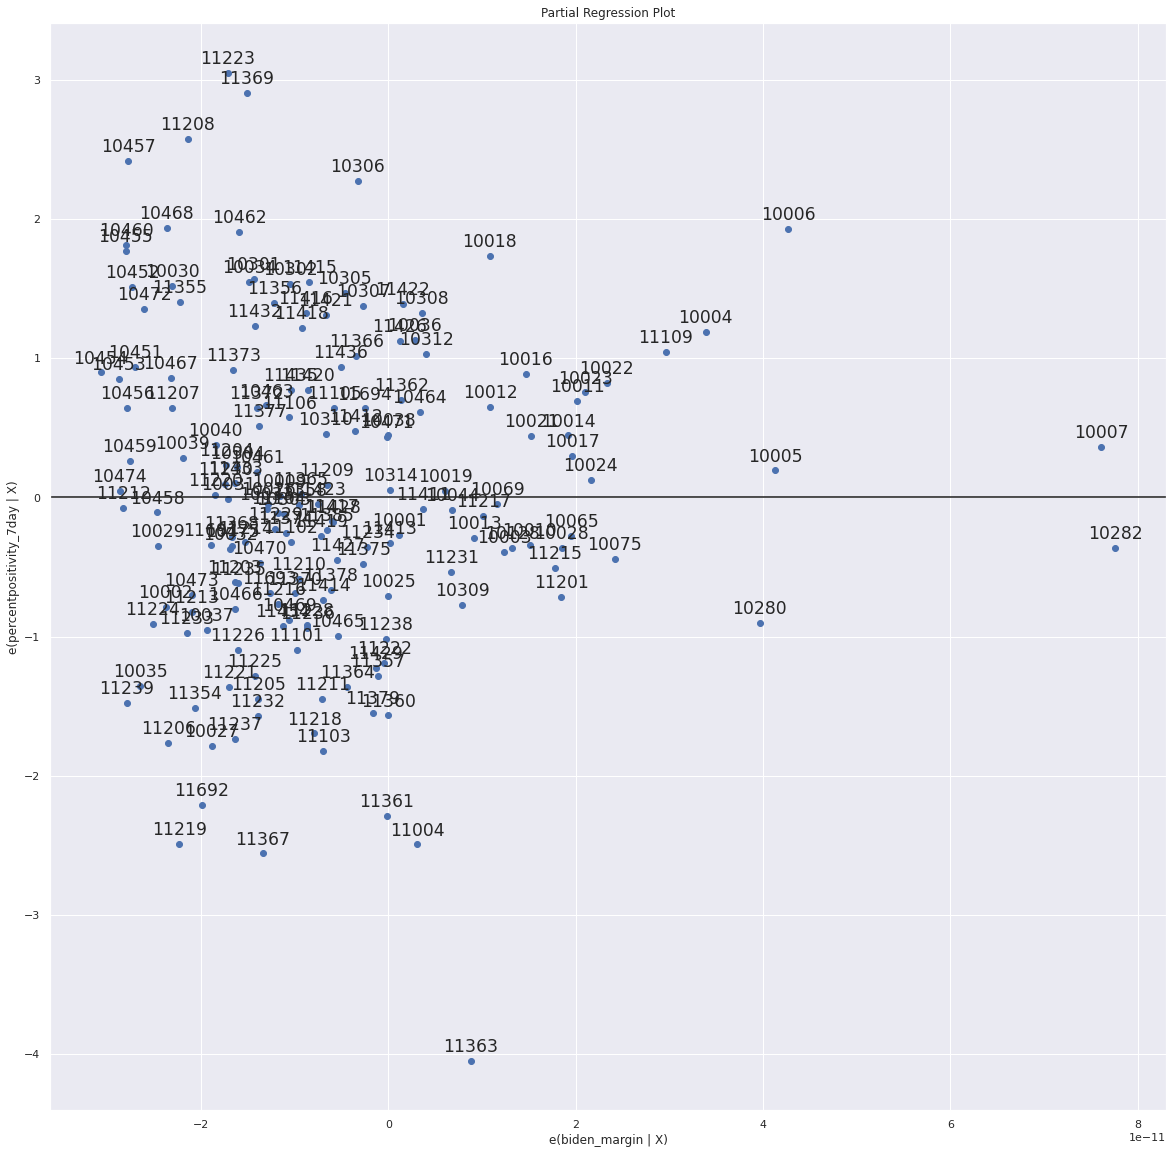

In [474]:
fig = sm.graphics.plot_partregress("percentpositivity_7day", "biden_margin", ["biden_margin", "median_income", "avg_num_people_per_household"], data=covid_vs_elections)
fig.set_size_inches(20, 20)

In [478]:
case_rate = pd.read_csv("/content/drive/MyDrive/covid_election_data/caserate-by-modzcta.csv")
case_rate = case_rate.transpose()
case_rate["modzcta"] = case_rate.index.map(lambda s: int(s[-5:]) if s[-1].isdigit() else s)
case_rate.set_index("modzcta", inplace=True)
covid_vs_elections["case_rate"] = case_rate[15].drop("week_ending").astype(float)

In [479]:
percent_positive = pd.read_csv("/content/drive/MyDrive/covid_election_data/percentpositive-by-modzcta.csv")
percent_positive = percent_positive.transpose()
percent_positive["modzcta"] = percent_positive.index.map(lambda s: int(s[-5:]) if s[-1].isdigit() else s)
percent_positive.set_index("modzcta", inplace=True)
covid_vs_elections["percent_positive"] = percent_positive[15].drop("week_ending").astype(float)

In [480]:
test_rate = pd.read_csv("/content/drive/MyDrive/covid_election_data/testrate-by-modzcta.csv")
test_rate = test_rate.transpose()
test_rate["modzcta"] = test_rate.index.map(lambda s: int(s[-5:]) if s[-1].isdigit() else s)
test_rate.set_index("modzcta", inplace=True)
covid_vs_elections["test_rate"] = test_rate[15].drop("week_ending").astype(float)

In [481]:
lm2 = sm.OLS.from_formula("percent_positive ~ test_rate + biden_margin + median_income + avg_num_people_per_household", covid_vs_elections).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       percent_positive   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     54.89
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.06e-29
Time:                        22:30:51   Log-Likelihood:                -250.07
No. Observations:                 176   AIC:                             510.1
Df Residuals:                     171   BIC:                             526.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        3.7353      0.709      5.267      0.000       2.335       5.135
test_rate                       -0.0001   6.41e-05     -1.574      0.117      -0.000    2.57e-05
biden_margin                    -2.1589      0.230     -9.368      0.000      -2.614      -1.704
median_income                 -8.66e-06    2.8e-06     -3.098      0.002   -1.42e-05   -3.14e-06
avg_num_people_per_household     0.7349      0.187      3.934      0.000       0.366       1.104
==============================================================================
Omnibus:                        5.553   Durbin-Watson:                   1.388
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.343
Skew:                           0.424   Prob(JB):                       0.0691
Kurtosis:                       3.093   Cond. No.                     7.85e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

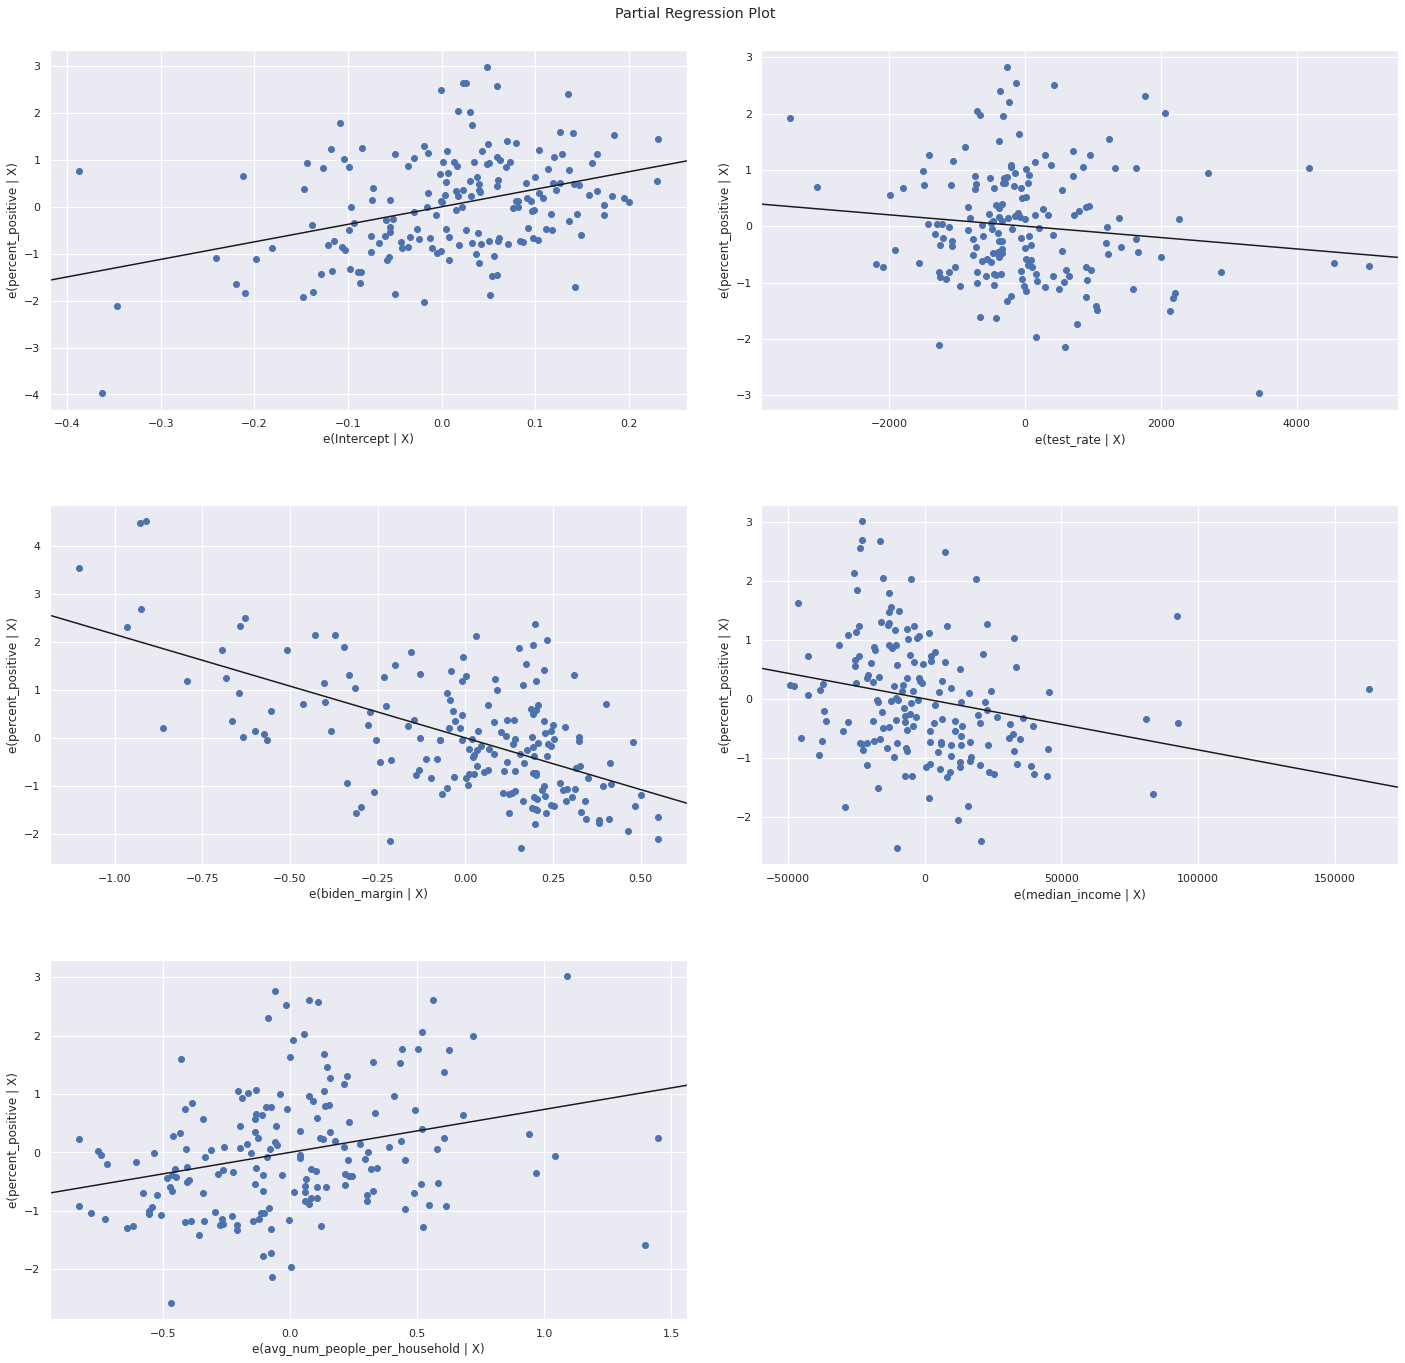

In [482]:
fig = sm.graphics.plot_partregress_grid(lm2)
fig.set_size_inches(20, 20)

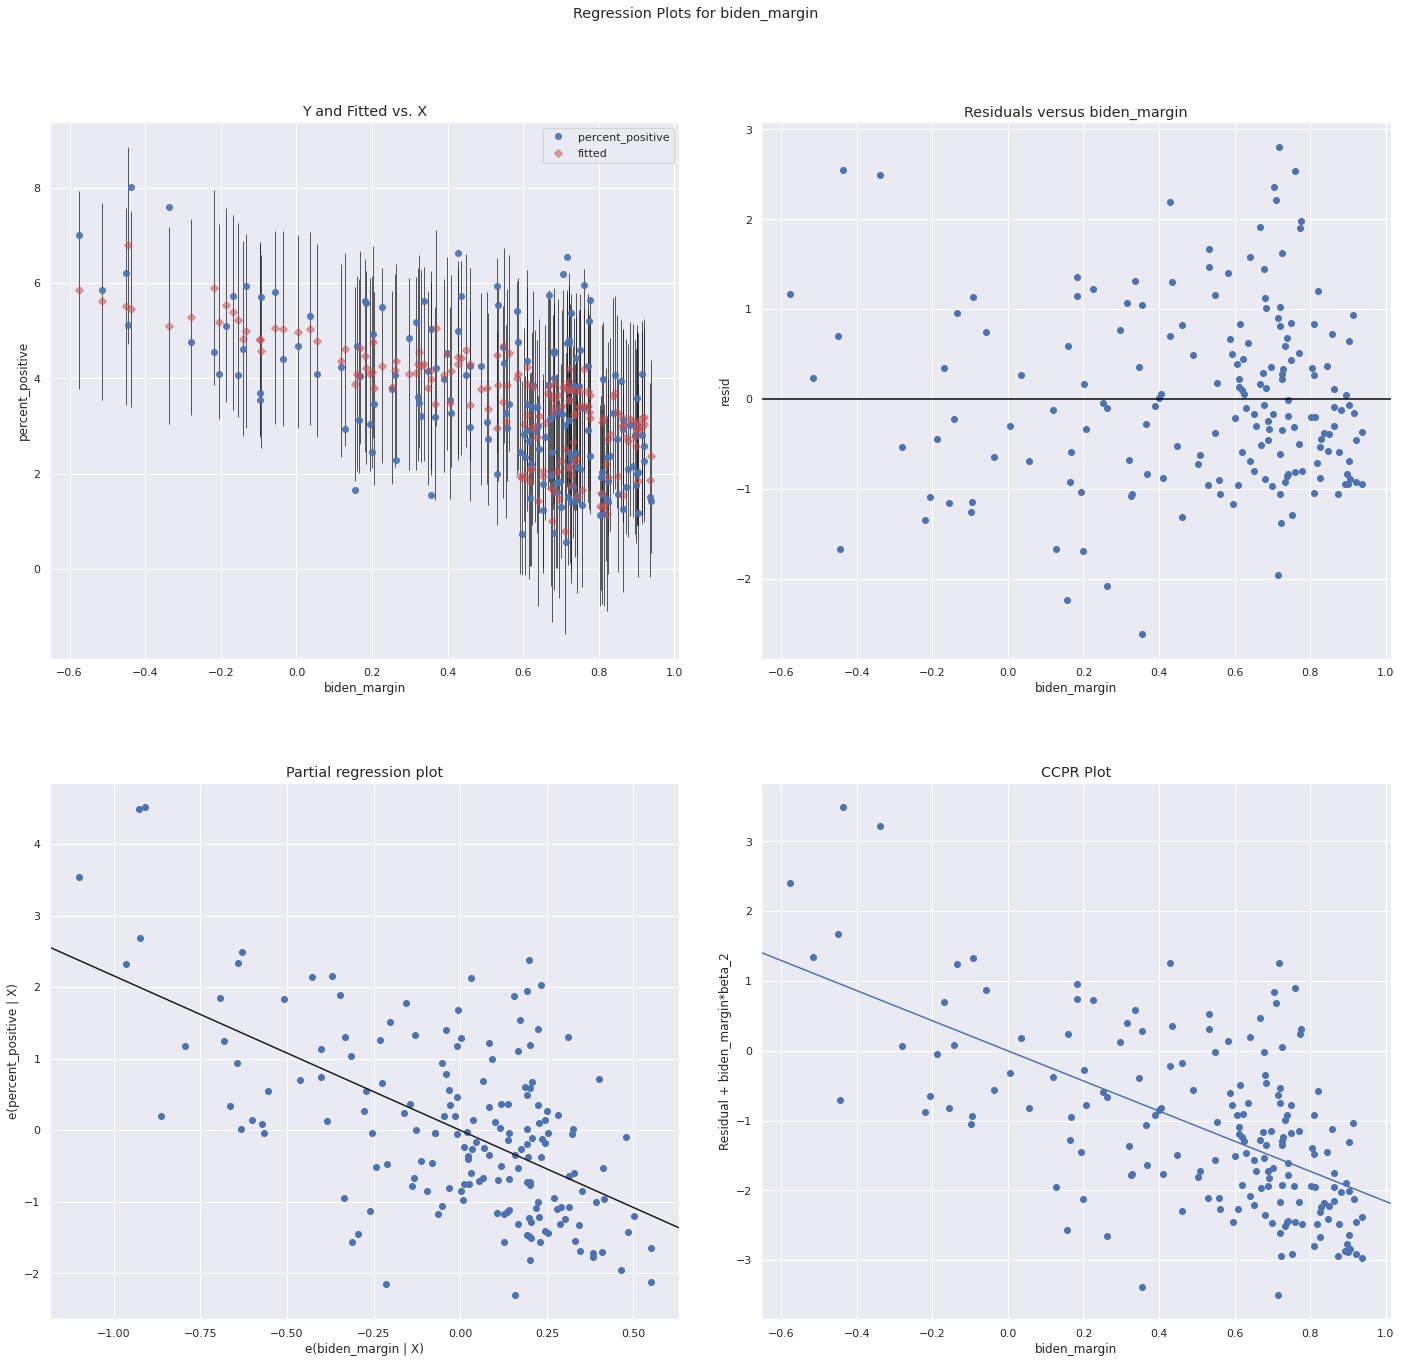

In [483]:
fig = sm.graphics.plot_regress_exog(lm2, "biden_margin")
fig.set_size_inches(20, 20)

In [489]:
lm_case_rate = sm.OLS.from_formula("case_rate ~ percent_positive + biden_margin + median_income + avg_num_people_per_household", covid_vs_elections).fit()
lm_case_rate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              case_rate   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     75.24
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.11e-36
Time:                        22:31:28   Log-Likelihood:                -868.41
No. Observations:                 176   AIC:                             1747.
Df Residuals:                     171   BIC:                             1763.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       30.6244     20.910      1.465      0.145     -10.650      71.898
percent_positive                37.0088      2.548     14.526      0.000      31.980      42.038
biden_margin                    16.2516      9.466      1.717      0.088      -2.434      34.937
median_income                    0.0006   8.31e-05      7.710      0.000       0.000       0.001
avg_num_people_per_household   -30.6502      5.933     -5.166      0.000     -42.361     -18.939
==============================================================================
Omnibus:                       50.799   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.996
Skew:                           1.172   Prob(JB):                     5.39e-32
Kurtosis:                       6.761   Cond. No.                     6.98e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

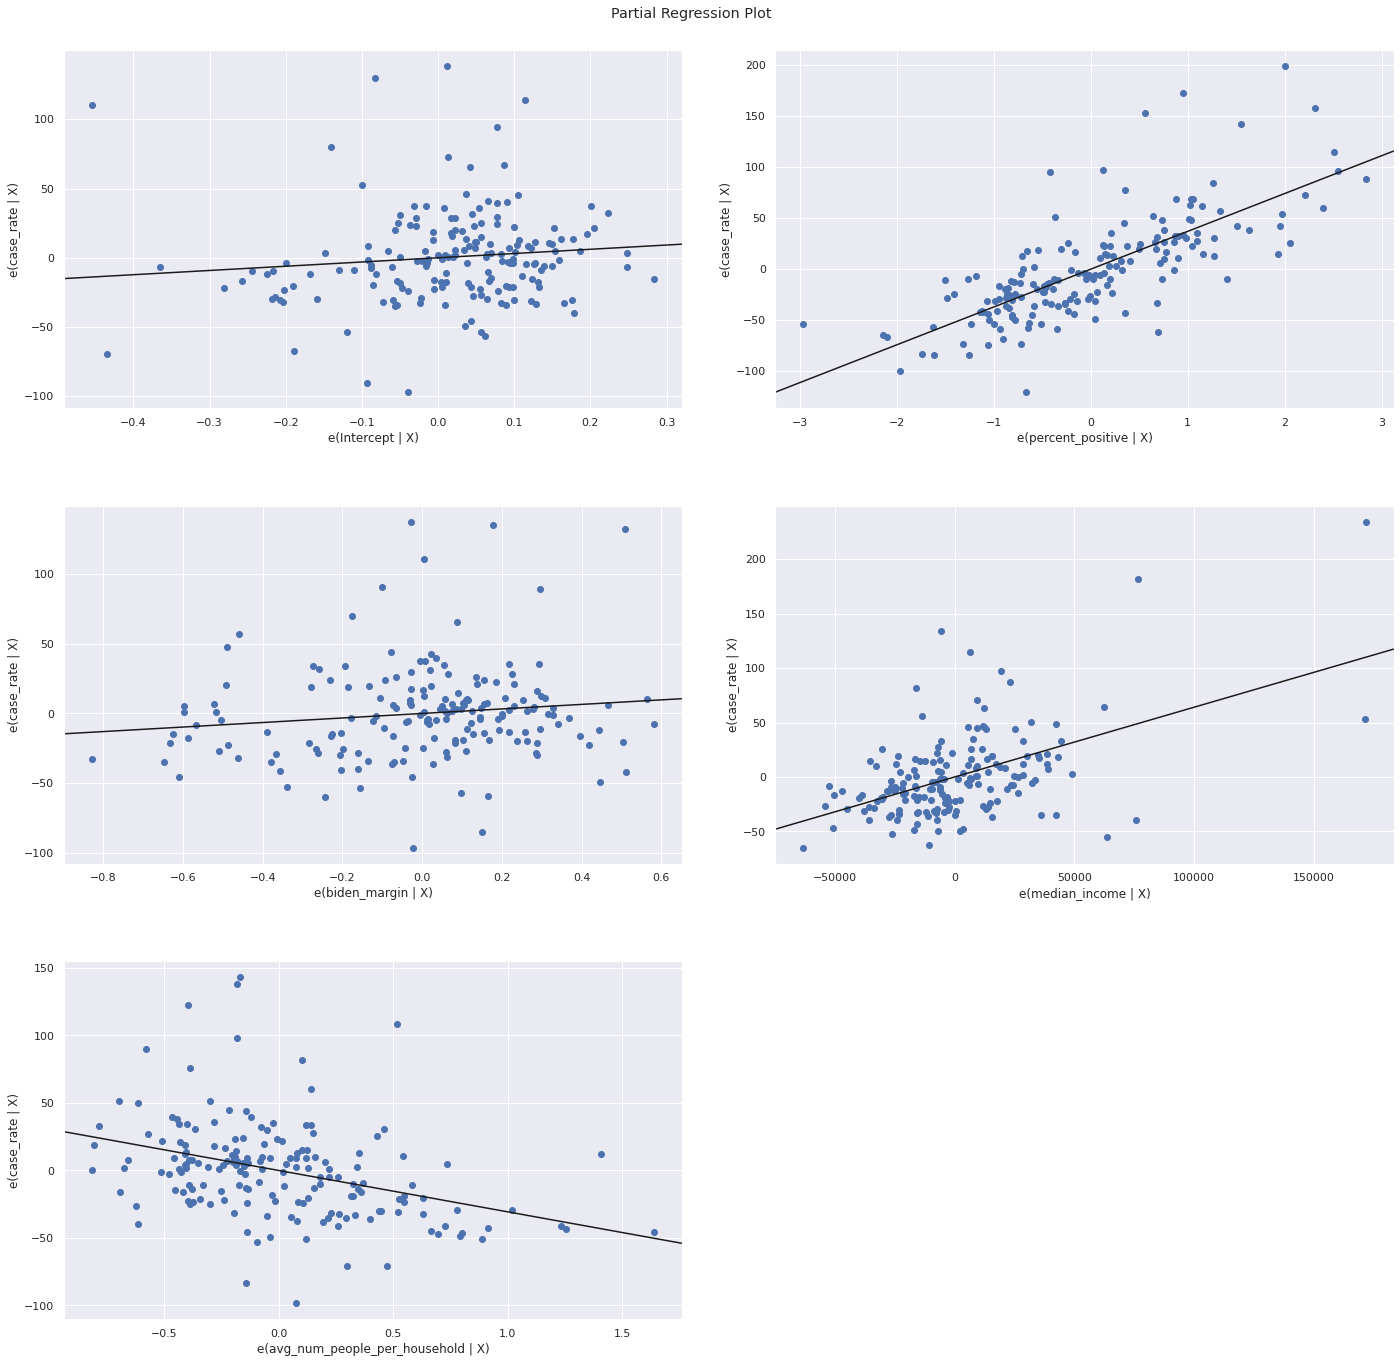

In [490]:
fig = sm.graphics.plot_partregress_grid(lm_case_rate)
fig.set_size_inches(20, 20)

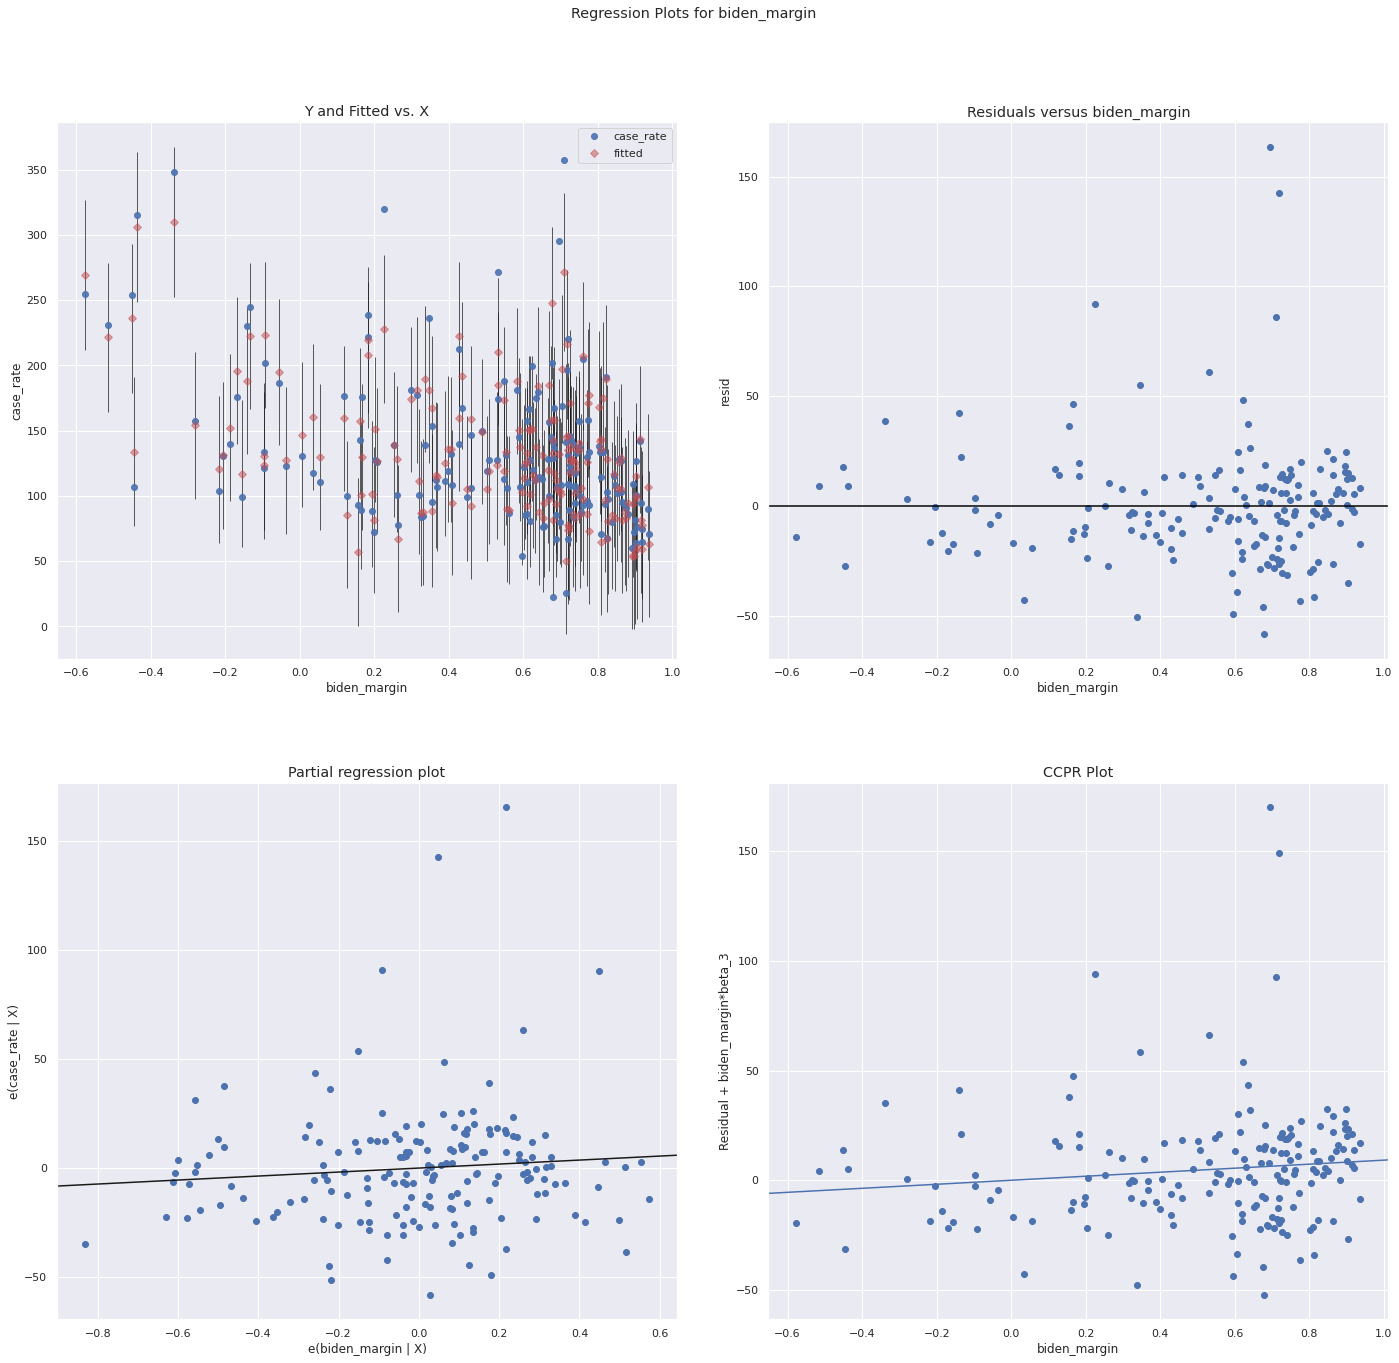

In [486]:
fig = sm.graphics.plot_regress_exog(lm_case_rate, "biden_margin")
fig.set_size_inches(20, 20)